# Deep Convolutional Generative Adversarial Networks with TensorFlow

 In this tutorial, we will try to build a GAN that is able to generate human faces with TensorFlow. Sounds scary, doesn’t it?


## Setup

Used Libraries:
* matplotlib
* PIL / Pillow
* numpy
* requests
* tqdm
* TensorFlow

## Splitting the Fairface Dataset

The original Fairface dataset has 97698 images, each of which is annotated with the subject's gender (i.e. Female or Male), race (White, Black, Middle Eastern, Indian, East Asian, Southeast Asian, or Latino/Hispanic), and age (). These images were originally collected from the YFCC-100M Flickr dataset

In [2]:
data_dir = './data'

import csv
training_labels = data_dir + '/fairface/fairface_label_train.csv'
val_labels = data_dir + '/fairface/fairface_label_val.csv'

female_east_asian = []
male_east_asian = []

female_white = []
male_white = []

female_black = []
male_black = []

female_middle_eastern = []
male_middle_eastern = []

female_indian = []
male_indian = []

female_southeast_asian = []
male_southeast_asian = []

female_latino_hispanic = []
male_latino_hispanic = []

with open(training_labels, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    for row in csv_reader:
        if row["gender"] == "Female":
            if row["race"] == "East Asian":
                female_east_asian.append(row["file"])
            elif row["race"] == "White":
                female_white.append(row["file"])
            elif row["race"] == "Black":
                female_black.append(row["file"])
            elif row["race"] == "Middle Eastern":
                female_middle_eastern.append(row["file"])
            elif row["race"] == "Indian":
                female_indian.append(row["file"])
            elif row["race"] == "Southeast Asian":
                female_southeast_asian.append(row["file"])
            elif row["race"] == "Latino_Hispanic":
                female_latino_hispanic.append(row["file"])
        else:
            if row["race"] == "East Asian":
                male_east_asian.append(row["file"])
            elif row["race"] == "White":
                male_white.append(row["file"])
            elif row["race"] == "Black":
                male_black.append(row["file"])
            elif row["race"] == "Middle Eastern":
                male_middle_eastern.append(row["file"])
            elif row["race"] == "Indian":
                male_indian.append(row["file"])
            elif row["race"] == "Southeast Asian":
                male_southeast_asian.append(row["file"])
            elif row["race"] == "Latino_Hispanic":
                male_latino_hispanic.append(row["file"])
    
with open(val_labels, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    for row in csv_reader:
        if row["gender"] == "Female":
            if row["race"] == "East Asian":
                female_east_asian.append(row["file"])
            elif row["race"] == "White":
                female_white.append(row["file"])
            elif row["race"] == "Black":
                female_black.append(row["file"])
            elif row["race"] == "Middle Eastern":
                female_middle_eastern.append(row["file"])
            elif row["race"] == "Indian":
                female_indian.append(row["file"])
            elif row["race"] == "Southeast Asian":
                female_southeast_asian.append(row["file"])
            elif row["race"] == "Latino_Hispanic":
                female_latino_hispanic.append(row["file"])
        else:
            if row["race"] == "East Asian":
                male_east_asian.append(row["file"])
            elif row["race"] == "White":
                male_white.append(row["file"])
            elif row["race"] == "Black":
                male_black.append(row["file"])
            elif row["race"] == "Middle Eastern":
                male_middle_eastern.append(row["file"])
            elif row["race"] == "Indian":
                male_indian.append(row["file"])
            elif row["race"] == "Southeast Asian":
                male_southeast_asian.append(row["file"])
            elif row["race"] == "Latino_Hispanic":
                male_latino_hispanic.append(row["file"])
                
print(len(female_east_asian) + len(male_east_asian) + len(female_white) +len(male_white) + len(female_black) + len(male_black) + len(female_middle_eastern) + len(male_middle_eastern) + len(female_indian) + len(male_indian) + len(female_southeast_asian) + len(male_southeast_asian) + len(female_latino_hispanic) + len(male_latino_hispanic))

from shutil import copy

images_by_group = {
    "female_east_asian": female_east_asian,
    "male_east_asian": male_east_asian,
    "female_white": female_white,
    "male_white": male_white,
    "female_black": female_black,
    "male_black": male_black,
    "female_middle_eastern": female_middle_eastern,
    "male_middle_eastern": male_middle_eastern,
    "female_indian": female_indian,
    "male_indian": male_indian,
    "female_southeast_asian": female_southeast_asian,
    "male_southeast_asian": male_southeast_asian,
    "female_latino_hispanic": female_latino_hispanic,
    "male_latino_hispanic": male_latino_hispanic
}

for group in images_by_group.keys():
    print("Working on group: ", group)
    images_to_move = images_by_group[group]
    destination = "./data/fairface/" + group + "/"
    for image in images_to_move:
        source = "./data/fairface/" + image
        copy(source, destination)



97698
Working on group:  female_east_asian
Working on group:  male_east_asian
Working on group:  female_white
Working on group:  male_white
Working on group:  female_black
Working on group:  male_black
Working on group:  female_middle_eastern
Working on group:  male_middle_eastern
Working on group:  female_indian
Working on group:  male_indian
Working on group:  female_southeast_asian
Working on group:  male_southeast_asian
Working on group:  female_latino_hispanic
Working on group:  male_latino_hispanic


## Cropping and Normalizing

Here we define a function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. To get some better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their values are in a range from -0,5 to +0,5. At last, we are going to downscale the images to 28x28. We run the following cells on each subgroup (each gender/race combination), so 14 times.

139021
number of images in this set 1000


/miniconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


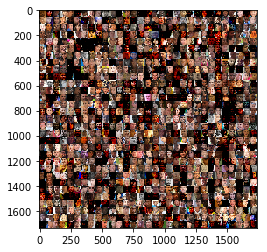

In [6]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot # helps us create plots
from PIL import Image # python image library used for image manipulation
import numpy as np # used for fun matrix/vector math/ML calculations
import helper

# change group depending on which one we are generating images for
data_dir_race_gender = './data/female_black'


data_files = glob(os.path.join(data_dir_race_gender, '*jpg'))
print(len(data_files))

# Image normalization and configuration 
# tried to  change to 42*42 to create better quality images, but this network isn't complex enough to do so
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
# normalize size of images
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    # open up image
    image = Image.open(image_path)

    # normalizing size of image if it isn't the size we want
    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 224
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    
    # convert image to array of pixels that we can train on 
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255

    # more normalization
    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        

test_images = get_batch(data_files[0:9], 56, 56)
print("number of images in this set", len(test_images))
pyplot.imshow(helper.images_square_grid(test_images))

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. We are doing this to not clutter the training function any more than it already is. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [8]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

## The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images (and see how close the fake image is to the real image). Simply said, this is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [121]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

## The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [122]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected (dense) layer
        # need to use dense 
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [123]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

## Optimization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [124]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [125]:
import csv
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(helper.images_square_grid(samples))
    pyplot.show()

def save_generator_output(sess, n_images, input_z, out_channel_dim, steps, epoch_count):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    count = 0
    for sample in samples:
        pyplot.imshow(sample)
        dir_to_save = data_dir_race_gender + str(steps) + "_" + str(epoch_count) + "_" + str(count)
        pyplot.savefig(dir_to_save)
        count += 1

def save_stats(toCSV):
    """
    Save stats to csv
    train_loss_g, train_loss_d, epoch_i, learning_rate, beta1
    """
    keys = toCSV[0].keys()
    file = data_dir_race_gender + "stats.csv"
    with open(file, 'wb') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(toCSV)
    

## Training

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady - and we mean slowly but steady! This progress can take up some hours based on your setup.

In [126]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
#     stats = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 200 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                         "Alpha...".format(learning_rate))
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])
                    
                if epoch_i == epoch_count-1:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                         "Alpha...".format(learning_rate))
                    
                    _ = save_generator_output(sess, 32, input_z, data_shape[3], steps, epoch_i)


Epoch 4/30... Discriminator Loss: 0.9814... Generator Loss: 1.2229 Alpha...


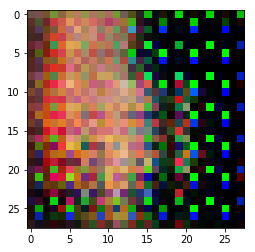

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
epochs = 30

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)